In [1]:
import sys
import os
import subprocess

from six import string_types

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [19]:
## Exploratory Data Analysis

In [4]:
num_images_to_load = 1000  # Load only the first 100 images for analysis
data_subset = data.head(num_images_to_load)

In [2]:
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer

# Load the dataset
data = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/train_classes.csv')  

# Data directory where the images are stored
data_dir = '/kaggle/input/planets-dataset/planet/planet/train-jpg'  

# Function to load images
def load_image(image_name):
    img_path = os.path.join(data_dir, image_name + '.jpg')  # Assuming the images are in JPEG format
    img = Image.open(img_path)
    return img

# Load the images and store them in a new 'image' column
data['image'] = data['image_name'].apply(load_image)

# Convert the labels into a list of tags
data['tags'] = data['tags'].apply(lambda x: x.split())

# Convert the tags into a usable format for multi-label classification (one-hot encoding)
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(data['tags'])
num_classes = len(mlb.classes_)

# Add the one-hot encoded tags to the DataFrame
for i, tag in enumerate(mlb.classes_):
    data[tag] = tags_encoded[:, i]

# Display the processed DataFrame
print(data.head())

# Display an example image
image_index = 0  # Change this index to visualize different images
data['image'][image_index].show()

# Display the corresponding tags for the example image
print("Tags for image:", data['tags'][image_index])


  image_name                                             tags  \
0    train_0                                  [haze, primary]   
1    train_1             [agriculture, clear, primary, water]   
2    train_2                                 [clear, primary]   
3    train_3                                 [clear, primary]   
4    train_4  [agriculture, clear, habitation, primary, road]   

                                               image  agriculture  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...            0   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...            1   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...            0   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...            0   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...            1   

   artisinal_mine  bare_ground  blooming  blow_down  clear  cloudy  \
0               0            0         0          0      0       0   
1               0            0         0          0   

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpv2c7zo_c.PNG'


/tmp/ipykernel_29/1678839641.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset.loc[:,'image'] = data_subset['image'].apply(preprocess_image)


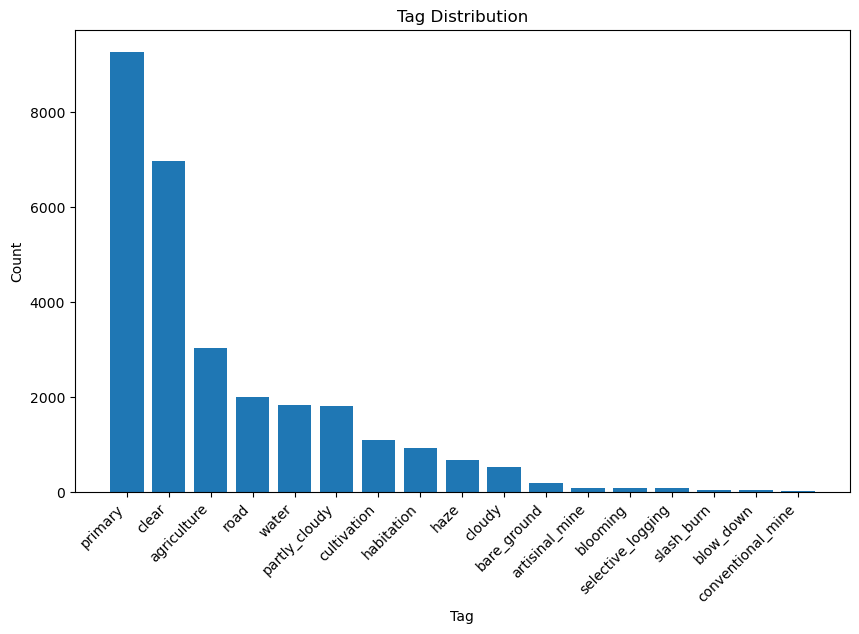

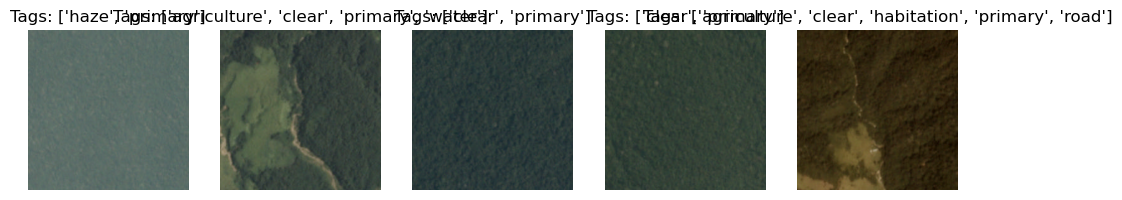

In [8]:
import matplotlib.pyplot as plt

# Data Preprocessing

# Resize the images to a fixed size (e.g., 224x224 for VGG or ResNet models)
fixed_size = (224, 224)  

def preprocess_image(img):
    return img.resize(fixed_size)

data_subset.loc[:,'image'] = data_subset['image'].apply(preprocess_image)

# Exploratory Data Analysis (EDA)

# Plot the distribution of tags
tag_counts = data_subset['tags'].explode().value_counts()
plt.figure(figsize=(10, 6))
plt.bar(tag_counts.index, tag_counts.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.title('Tag Distribution')
plt.show()

# Visualize multiple images with their corresponding tags
num_images_to_visualize = 5  
plt.figure(figsize=(12, 8))
for i in range(num_images_to_visualize):
    plt.subplot(1, num_images_to_visualize, i + 1)
    plt.imshow(data['image'][i])
    plt.title(f'Tags: {data["tags"][i]}')
    plt.axis('off')
plt.show()


In [5]:
from PIL import Image
import numpy as np

def load_and_preprocess_image(file_path, target_size):
    # Load image using PIL
    image = Image.open(file_path)

    # Resize the image to the target size
    image = image.resize(target_size)

    # Convert image to numpy array
    image_array = np.array(image)

    # Normalize the image by dividing by 255 (assuming pixel values are in the range [0, 255])
    image_array = image_array / 255.0

    return image_array

# Example usage:
image_file_path = '/kaggle/input/planets-dataset/planet/planet/test-jpg/test_0.jpg'
target_size = (224, 224)  # Set the desired target size

image_array = load_and_preprocess_image(image_file_path, target_size)
print(image_array.shape)  # Output: (224, 224, 3) for RGB images

# You can loop through all the image filenames in your DataFrame and preprocess them
# Example using the 'train_data' DataFrame:
image_data = []
for file_name in data_subset['image_name']:
    image_file_path = f'/kaggle/input/planets-dataset/planet/planet/train-jpg/{file_name}.jpg'
    image_array = load_and_preprocess_image(image_file_path, target_size)
    image_data.append(image_array)

image_data = np.array(image_data)
print(image_data.shape)  # Output: (num_samples, 224, 224, 3) for RGB images


(224, 224, 4)
(1000, 224, 224, 4)


In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))  # Use sigmoid activation for multi-label classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [8]:
# Specify the number of epochs and batch size
epochs = 10
batch_size = 32

# Train the model on the training data
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_data) // batch_size
)


NameError: name 'train_generator' is not defined

In [7]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator, steps=len(val_data) // batch_size)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


NameError: name 'val_generator' is not defined

In [ ]:
# Make predictions on the test set
test_predictions = model.predict(test_generator, steps=len(test_data) // batch_size)


In [ ]:
# Threshold the probabilities to get binary predictions based on a chosen threshold
threshold = 0.5
binary_predictions = (test_predictions > threshold).astype(int)


In [ ]:
# Format the predictions for submission (assuming test_data has an 'image_name' column)
submission = pd.DataFrame(data=binary_predictions, columns=mlb.classes_)
submission['image_name'] = test_data['image_name']
submission.to_csv('submission.csv', index=False)
